# Lung Cancer Detection with chest X-Ray images


This notebook reproduces the methodology described in the following paper: https://github.com/schaudhuri16/LungCancerDetection


- Dataset created form the CheXpert dataset (https://www.kaggle.com/datasets/ashery/chexpert)
- Data augmentation using a Variational Autoencoder (VAE)
- Supervised classification using AlexNet and DenseNet architectures


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import shutil

from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision.utils import save_image
import shutil


from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [3]:
# Paths
csv_path = "/kaggle/input/chexpert/train.csv"
images_base_path = "/kaggle/input/chexpert/train"

PROJECT_ROOT = "/kaggle/working"
output_base_path = os.path.join(PROJECT_ROOT, "dataset")

# Dataset Processing

In [4]:
#Loading the csv file
df = pd.read_csv(csv_path)

df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


### **Definition of the labels**

In the paper, the "lung lesions" are considered to be signs of lung cancer. This is why we will focus only on that feature for classification.

In the dataset, there are 3 possible values:
- 1.0 (lesion)
- 0.0 (no lesion)
- -1.0 (uncertain)

Based on the paper's work, we decided to create 2 labels: `1` for the malignant class (there is lung cancer) and `0` for the negative/benign class (no lung cancer):

- 1.0 is mapped to the malignant class (1)
- 0.0, -1.0 and NaN are mapped to the benign class (0)

In [5]:
df = df.copy()

df["label"] = df["Lung Lesion"].apply(
    lambda x: 1 if x == 1.0 else 0
)

In [6]:
df["label"].value_counts()

label
0    214228
1      9186
Name: count, dtype: int64

### **Dataset balancing**

The original dataset is imbalanced with much less positive samples.

To match more or less the numbers described in the paper, an almost equal number of benign and malignant images are selected by subsampling class `0`.

In [ ]:
df_pos = df[df["label"] == 1]
df_neg = df[df["label"] == 0]

print("Before balancing:")
print(df_pos.shape, df_neg.shape)

# Subsampling the negative class to match positive class
df_neg_balanced = df_neg.sample(
    n=len(df_pos),
    random_state=42
)

# Combining and shuffling
df_balanced = pd.concat([df_pos, df_neg_balanced]).sample(
    frac=1,
    random_state=42
)

print("After balancing:")
print(df_balanced["label"].value_counts())


Before balancing:
(9186, 20) (214228, 20)
After balancing:
label
0    9186
1    9186
Name: count, dtype: int64


### **Dataset splitting into training, validation and test sets**

In [8]:
# Splitting into train, test, val
train_val_df, test_df = train_test_split(
    df_balanced, 
    test_size=0.2, 
    stratify=df_balanced["label"], 
    random_state=42
)

train_df, val_df = train_test_split(
    train_val_df, 
    test_size=0.2, 
    stratify=train_val_df["label"], 
    random_state=42
)

print("Train:", train_df["label"].value_counts())
print("Validation:", val_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())


Train: label
1    5879
0    5878
Name: count, dtype: int64
Validation: label
1    1470
0    1470
Name: count, dtype: int64
Test: label
0    1838
1    1837
Name: count, dtype: int64


### **Copying the selected images**

We copy the selected images into folders with a structure compatible with PyTorch.

In [9]:
def copy_images(df, split_name):
    for idx, row in df.iterrows():
        label = str(row["label"])
        img_path = os.path.join(images_base_path, os.path.relpath(row["Path"], "CheXpert-v1.0-small/train"))
        out_dir = os.path.join(output_base_path, split_name, label)
        os.makedirs(out_dir, exist_ok=True)

        patient_folder = os.path.basename(os.path.dirname(os.path.dirname(img_path)))
        original_filename = os.path.basename(img_path)
        new_filename = f"{patient_folder}_{original_filename}"

        dest_path = os.path.join(out_dir, new_filename)
        shutil.copy(img_path, dest_path)

copy_images(train_df, "train")
copy_images(val_df, "val")
copy_images(test_df, "test")


### **Image Preprocessing**

To enhance the training data, we realize random resized crops and horizontal flips.

Then, we normalize the images with ImageNet like it was mentionned in the paper.

In [10]:
# ImageNet normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = datasets.ImageFolder(os.path.join(output_base_path, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(output_base_path, "val"), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(output_base_path, "test"), transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Variational Autoencoder (VAE)

Because the number of images in the training set is not huge, the paper wants to augment the training dataset by creating, training and using a **VAE** to generate synthetic chest X-ray images.

### **Architectural Adaptation**

The VAE architecture proposed by the paper is pretty huge and because of computational limitations on our part, we will implement a lighter VAE with less convolutional layers and a smaller latent dimensionality

This version is certainly less performant than their version but it remains ok to generate diverse and realistic data.

---

We also created a Conditional Variational Autoencoder (CVAE) instead of a standard VAE where the class label is also given as input. This way we don't have to train 2 VAE on each class.


In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)  # 128 -> 64
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)  # 64 -> 32
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)  # 32 -> 16
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)  # 16 -> 8
        self.fc_mu = nn.Linear(256*8*8 + 1, latent_dim)  # +1 for class label
        self.fc_logvar = nn.Linear(256*8*8 + 1, latent_dim)

    def forward(self, x, c):
        c = c.float().view(-1, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = torch.cat([x, c], dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.fc = nn.Linear(latent_dim + 1, 256*8*8)  # +1 for class label
        self.conv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)  # 8 -> 16
        self.conv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)  # 16 -> 32
        self.conv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)  # 32 -> 64
        self.conv4 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)  # 64 -> 128

    def forward(self, z, c):
        c = c.float().view(-1, 1)
        z = torch.cat([z, c], dim=1)
        x = self.fc(z)
        x = x.view(-1, 256, 8, 8)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

class CVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z, c)
        return recon, mu, logvar


In [12]:
def cvae_loss(recon_x, x, mu, logvar, beta=0.1):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

In [13]:
vae_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Converts to [0, 1] by default
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
])

# Load dataset
full_dataset = datasets.ImageFolder(root="dataset/train", transform=vae_transforms)

# Split into benign (0) and malignant (1)
benign_indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label == 0]
malignant_indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label == 1]

# Create subsets
benign_dataset = torch.utils.data.Subset(full_dataset, benign_indices)
malignant_dataset = torch.utils.data.Subset(full_dataset, malignant_indices)

# Combine for CVAE (with labels)
class LabeledDataset(Dataset):
    def __init__(self, dataset, label):
        self.dataset = dataset
        self.label = label

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        return x, self.label

# Combine datasets
cvae_dataset = torch.utils.data.ConcatDataset([
    LabeledDataset(benign_dataset, 0),
    LabeledDataset(malignant_dataset, 1)
])

# DataLoader
cvae_loader = DataLoader(cvae_dataset, batch_size=32, shuffle=True, drop_last=True)


In [14]:
def train_cvae(model, train_loader, epochs=30, lr=1e-4):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, c in train_loader:
            x, c = x.to(device), c.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(x, c)
            loss = cvae_loss(recon, x, mu, logvar)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item() * x.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        scheduler.step(avg_train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}")

In [15]:
cvae = CVAE().to(device)
train_cvae(cvae, cvae_loader)

Epoch [1/30], Train Loss: 0.6292
Epoch [2/30], Train Loss: 0.5841
Epoch [3/30], Train Loss: 0.5784
Epoch [4/30], Train Loss: 0.5764
Epoch [5/30], Train Loss: 0.5750
Epoch [6/30], Train Loss: 0.5743
Epoch [7/30], Train Loss: 0.5737
Epoch [8/30], Train Loss: 0.5732
Epoch [9/30], Train Loss: 0.5728
Epoch [10/30], Train Loss: 0.5725
Epoch [11/30], Train Loss: 0.5722
Epoch [12/30], Train Loss: 0.5721
Epoch [13/30], Train Loss: 0.5717
Epoch [14/30], Train Loss: 0.5717
Epoch [15/30], Train Loss: 0.5714
Epoch [16/30], Train Loss: 0.5713
Epoch [17/30], Train Loss: 0.5710
Epoch [18/30], Train Loss: 0.5708
Epoch [19/30], Train Loss: 0.5707
Epoch [20/30], Train Loss: 0.5706
Epoch [21/30], Train Loss: 0.5705
Epoch [22/30], Train Loss: 0.5705
Epoch [23/30], Train Loss: 0.5703
Epoch [24/30], Train Loss: 0.5703
Epoch [25/30], Train Loss: 0.5701
Epoch [26/30], Train Loss: 0.5699
Epoch [27/30], Train Loss: 0.5699
Epoch [28/30], Train Loss: 0.5698
Epoch [29/30], Train Loss: 0.5698
Epoch [30/30], Train Lo

### **Synthetic Image Generation**

After traing the CVAE, we use it to create new images. We generate 1000 samples for both classes.

Afterwards, we merge the synthetic images with the original training set

In [ ]:
def generate_images(cvae, n_images, out_dir, class_label):
    cvae.eval()
    os.makedirs(out_dir, exist_ok=True)

    with torch.no_grad():
        c = torch.full((n_images,), class_label, device=device)
        z = torch.randn(n_images, 32).to(device)
        images = cvae.decoder(z, c).cpu()

        for i, img in enumerate(images):
            save_image(img, f"{out_dir}/synthetic_{i}.jpg")

# Generate 1000 benign images
generate_images(
    cvae,
    n_images=1000,
    out_dir="dataset/train/0_synthetic",
    class_label=0
)

# Generate 1000 malignant images
generate_images(
    cvae,
    n_images=1000,
    out_dir="dataset/train/1_synthetic",
    class_label=1
)

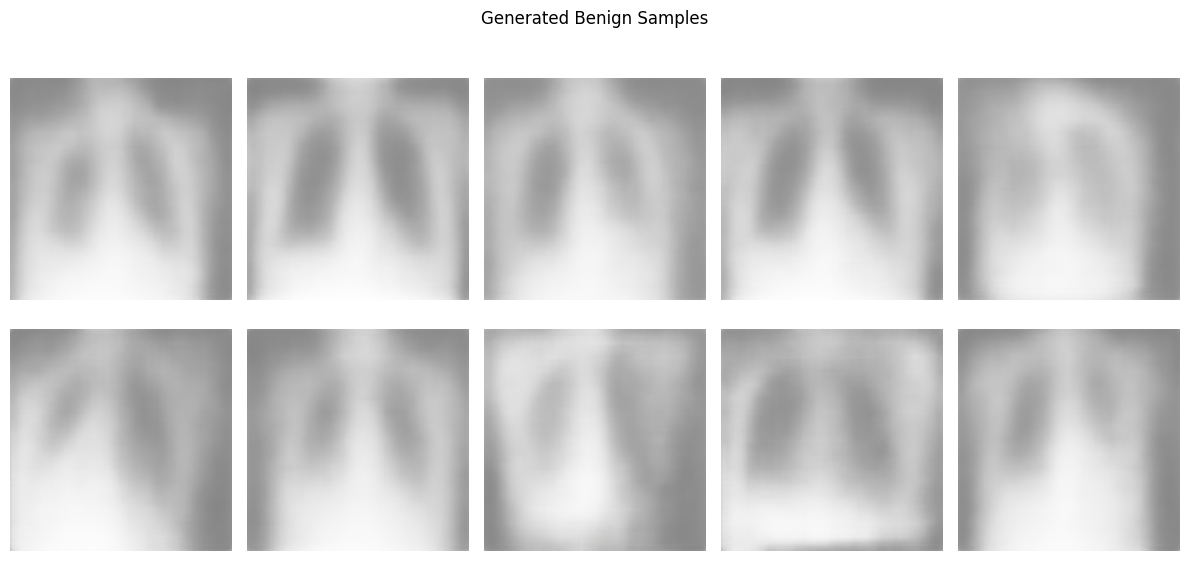

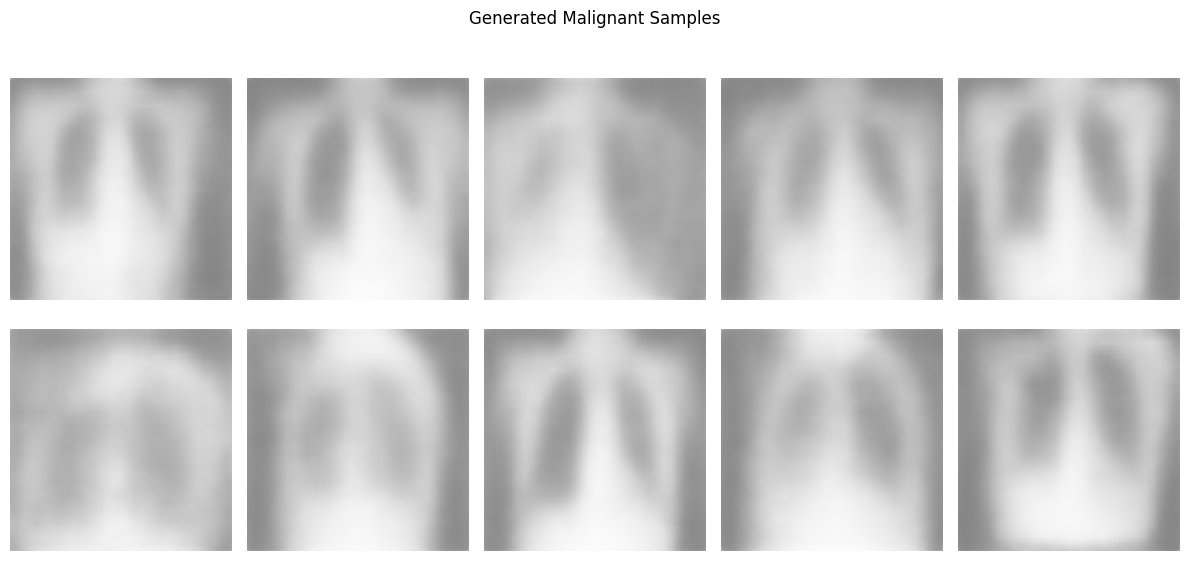

In [ ]:
def visualize_samples(images, title, n=10):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for ax, img in zip(axes.flatten(), images[:n]):
        img = img.permute(1, 2, 0).numpy()  # C, H, W -> H, W, C
        img = (img * 0.5) + 0.5
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualizing 10 samples from each class
with torch.no_grad():
    # Benign
    c_benign = torch.full((10,), 0, device=device)
    z_benign = torch.randn(10, 32).to(device)
    benign_samples = cvae.decoder(z_benign, c_benign).cpu()
    visualize_samples(benign_samples, "Generated Benign Samples")

    # Malignant
    c_malignant = torch.full((10,), 1, device=device)
    z_malignant = torch.randn(10, 32).to(device)
    malignant_samples = cvae.decoder(z_malignant, c_malignant).cpu()
    visualize_samples(malignant_samples, "Generated Malignant Samples")

In [18]:

def merge_synthetic(real_dir, synthetic_dir):
    for img in os.listdir(synthetic_dir):
        shutil.move(
            os.path.join(synthetic_dir, img),
            os.path.join(real_dir, img)
        )

    shutil.rmtree(os.path.join(PROJECT_ROOT,synthetic_dir))

merge_synthetic("dataset/train/0", "dataset/train/0_synthetic")
merge_synthetic("dataset/train/1", "dataset/train/1_synthetic")


# Training of the classification models

Based on the paper, we train 2 CNN to perform binary classification:
- AlexNet
- DenseNet

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [20]:
train_dataset = datasets.ImageFolder(
    root=os.path.join(output_base_path, "train"),
    transform=data_transforms['train']
)
val_dataset = datasets.ImageFolder(
    root=os.path.join(output_base_path, "val"),
    transform=data_transforms['val']
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [21]:
def get_alexnet():
    model = models.alexnet(pretrained=True)
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, 2)  # 2 classes: benign, malignant
    return model

def get_densenet():
    model = models.densenet121(pretrained=True)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, 2)  # 2 classes: benign, malignant
    return model


### **Transfer Learning Strategy**

We use a transfer learning approach and this allows the models to reuse generic visual features they already learned but also adapting specifically to the lung cancer classification task.


In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        val_loss, val_acc, all_labels, all_preds = evaluate_model(model, val_loader, criterion)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'{PROJECT_ROOT}/{model.__class__.__name__}_best_weights.pth')

    return model

def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = running_corrects.double() / len(val_loader.dataset)

    return val_loss, val_acc, all_labels, all_preds


In [23]:
def compute_metrics(labels, preds):
    cm = confusion_matrix(labels, preds)
    recall = recall_score(labels, preds)
    precision = precision_score(labels, preds)
    f1 = f1_score(labels, preds)
    accuracy = accuracy_score(labels, preds)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

    return cm, recall, precision, f1, accuracy


### **Training AlexNet**

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 216MB/s]  


Epoch 1/30, Train Loss: 0.5243, Train Acc: 0.5134, Val Loss: 0.8712, Val Acc: 0.4947
Epoch 2/30, Train Loss: 0.4984, Train Acc: 0.5270, Val Loss: 0.7208, Val Acc: 0.5622
Epoch 3/30, Train Loss: 0.4912, Train Acc: 0.5308, Val Loss: 0.8306, Val Acc: 0.5217
Epoch 4/30, Train Loss: 0.4869, Train Acc: 0.5427, Val Loss: 0.7978, Val Acc: 0.5551
Epoch 5/30, Train Loss: 0.4826, Train Acc: 0.5483, Val Loss: 0.9121, Val Acc: 0.5135
Epoch 6/30, Train Loss: 0.4739, Train Acc: 0.5603, Val Loss: 0.8410, Val Acc: 0.5501
Epoch 7/30, Train Loss: 0.4721, Train Acc: 0.5555, Val Loss: 0.7637, Val Acc: 0.5555
Epoch 8/30, Train Loss: 0.4665, Train Acc: 0.5677, Val Loss: 0.8155, Val Acc: 0.5420
Epoch 9/30, Train Loss: 0.4587, Train Acc: 0.5784, Val Loss: 0.8800, Val Acc: 0.5149
Epoch 10/30, Train Loss: 0.4552, Train Acc: 0.5841, Val Loss: 0.7789, Val Acc: 0.5644
Epoch 11/30, Train Loss: 0.4468, Train Acc: 0.5966, Val Loss: 0.6861, Val Acc: 0.5950
Epoch 12/30, Train Loss: 0.4411, Train Acc: 0.6038, Val Loss: 0

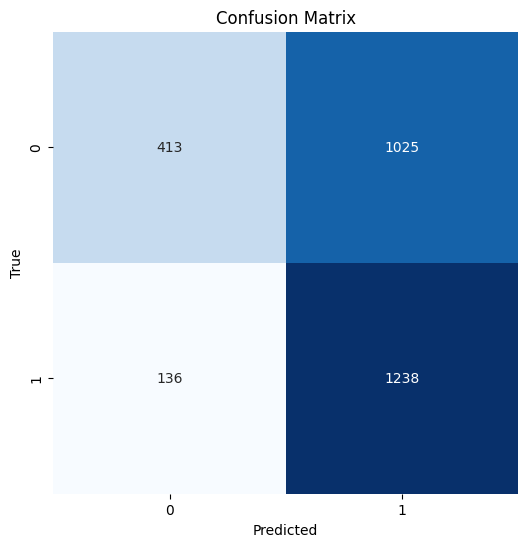

Recall: 0.9010
Precision: 0.5471
F1 Score: 0.6808
Accuracy: 0.5871


(array([[ 413, 1025],
        [ 136, 1238]]),
 0.901018922852984,
 0.5470614228899691,
 0.680780863348914,
 0.587126600284495)

In [24]:

alexnet = get_alexnet().to(device)

for param in alexnet.features.parameters():
    param.requires_grad = False

class_weights = torch.tensor([1.0, 4.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, alexnet.parameters()),
    lr=1e-4
)

alexnet = train_model(
    alexnet,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=30
)


# Evaluate
_, _, labels, preds = evaluate_model(alexnet, val_loader, criterion)
compute_metrics(labels, preds)


### **Training DenseNet**

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30.8M/30.8M [00:00<00:00, 162MB/s] 


Epoch 1/30, Train Loss: 0.6539, Train Acc: 0.6183, Val Loss: 0.6290, Val Acc: 0.6444
Epoch 2/30, Train Loss: 0.6119, Train Acc: 0.6578, Val Loss: 0.6097, Val Acc: 0.6611
Epoch 3/30, Train Loss: 0.5775, Train Acc: 0.6900, Val Loss: 0.7041, Val Acc: 0.6280
Epoch 4/30, Train Loss: 0.5281, Train Acc: 0.7305, Val Loss: 0.6443, Val Acc: 0.6611
Epoch 5/30, Train Loss: 0.4633, Train Acc: 0.7730, Val Loss: 0.6825, Val Acc: 0.6387
Epoch 6/30, Train Loss: 0.3989, Train Acc: 0.8160, Val Loss: 0.6930, Val Acc: 0.6348
Epoch 7/30, Train Loss: 0.3282, Train Acc: 0.8571, Val Loss: 0.8024, Val Acc: 0.6223
Epoch 8/30, Train Loss: 0.2555, Train Acc: 0.8966, Val Loss: 0.8936, Val Acc: 0.6433
Epoch 9/30, Train Loss: 0.2137, Train Acc: 0.9129, Val Loss: 0.9285, Val Acc: 0.6312
Epoch 10/30, Train Loss: 0.1744, Train Acc: 0.9319, Val Loss: 1.2166, Val Acc: 0.6287
Epoch 11/30, Train Loss: 0.1520, Train Acc: 0.9403, Val Loss: 1.1963, Val Acc: 0.6223
Epoch 12/30, Train Loss: 0.1233, Train Acc: 0.9546, Val Loss: 1

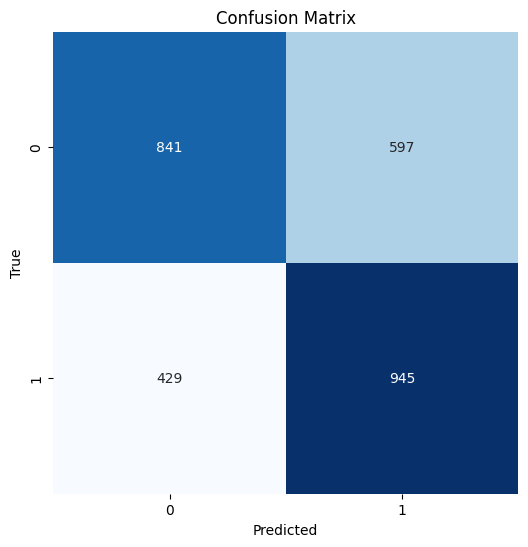

Recall: 0.6878
Precision: 0.6128
F1 Score: 0.6481
Accuracy: 0.6351


(array([[841, 597],
        [429, 945]]),
 0.6877729257641921,
 0.6128404669260701,
 0.6481481481481481,
 0.6351351351351351)

In [25]:
densenet = get_densenet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet.parameters(), lr=1e-4)

densenet = train_model(densenet, train_loader, val_loader, criterion, optimizer, num_epochs=30)

# Evaluate
_, _, labels, preds = evaluate_model(densenet, val_loader, criterion)
compute_metrics(labels, preds)

### **Saving model weights**

In [ ]:
SAVE_DIR = "/kaggle/working/models"
os.makedirs(SAVE_DIR, exist_ok=True)


torch.save(
    alexnet.state_dict(), 
    os.path.join(SAVE_DIR, "AlexNet_weights.pth"))


torch.save(
    densenet.state_dict(),
    os.path.join(SAVE_DIR, "DenseNet_weights.pth")
)